# Spectral Anomaly Detection (SAD)

This notebook demonstrates the Spectral Anomaly Detection algorithm for identifying radioactive sources in gamma-ray time series data.

## Algorithm Overview

The SAD detector:
1. **Learns background subspace** using PCA on source-absent training data
2. **Computes reconstruction error** for new spectra: SAD(x) = ||(I - UU^T)x||²
3. **Detects anomalies** when reconstruction error exceeds threshold
4. **Aggregates alarms** that are close in time

## Key Features
- **Unsupervised**: Only needs background data for training
- **Multivariate**: Captures correlations between energy channels
- **Interpretable**: Reconstruction error quantifies "how different from normal"

## Reference
NOTE: There is no guarantee that this is a faithful representation of the work described below!

Miller, K., & Dubrawski, A. (2018). Gamma-ray source detection with small sensors. IEEE Transactions on Nuclear Science, 65(4), 1047-1058.

## Dataset

Using the TopCoder Urban Data Challenge dataset (mobile NaI detector).


## Setup


In [1]:
# Imports
import sys
sys.path.insert(0, '/Users/jghawaly/CODE/gammaflow')
sys.path.insert(0, '/Users/jghawaly/CODE/urbandata-gammaflow')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

# GammaFlow imports
from gammaflow import Spectrum, SpectralTimeSeries, ListMode
from gammaflow.core.spectra import Spectra
from gammaflow.visualization import plot_count_rate_time_series

# Detection algorithm
from src.detectors import SADDetector

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

print("✅ SAD Detection - Ready!")


✅ SAD Detection - Ready!


/Users/jghawaly/CODE/gammaflow/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data Helper


In [2]:
def load_listmode_run(run_id, data_dir='../topcoder', dataset='training'):
    """Load a run and return ListMode object + metadata."""
    data_path = Path(data_dir)
    
    # Load listmode data
    run_file = data_path / dataset / f"{run_id}.csv"
    data = pd.read_csv(run_file, header=None, names=['time_delta_us', 'energy_keV'])
    
    # Convert to seconds
    time_deltas = data['time_delta_us'].values * 1e-6
    energies = data['energy_keV'].values
    
    # Load metadata
    answer_key_file = data_path / 'scorer' / f'answerKey_{dataset}.csv'
    answer_key = pd.read_csv(answer_key_file)
    metadata = answer_key[answer_key['RunID'] == run_id].iloc[0].to_dict()
    
    # Map SourceID to source name
    source_map = {
        0: 'Background',
        1: 'HEU',
        2: 'WGPu',
        3: 'I-131',
        4: 'Co-60',
        5: 'Tc-99m',
        6: 'Tc-99m + HEU'
    }
    metadata['SourceName'] = source_map.get(metadata['SourceID'], f"Unknown({metadata['SourceID']})")
    
    # Create ListMode
    listmode = ListMode(time_deltas, energies)
    
    return listmode, metadata

print("✅ Load function ready")


✅ Load function ready


## Load Background Training Data

For SAD, we need background-only data to learn the "normal" spectral subspace via PCA.


In [3]:
# Load ALL background runs for training
# First, identify all background runs from the answer key
data_path = Path('../topcoder')
answer_key_file = data_path / 'scorer' / 'answerKey_training.csv'
answer_key = pd.read_csv(answer_key_file)

# Get all background runs (SourceID == 0)
background_runs = answer_key[answer_key['SourceID'] == 0]
background_run_ids = background_runs['RunID'].values

print(f"Found {len(background_run_ids)} background runs in the dataset")
print(f"Loading all background runs for training...")

background_spectra_list = []
total_spectra = 0

for run_id in tqdm(background_run_ids):
    try:
        listmode, metadata = load_listmode_run(run_id)
        
        # Convert to time series (5-second integration for more training samples)
        ts = SpectralTimeSeries.from_list_mode(
            listmode,
            integration_time=5.0,
            stride_time=5.0,
            energy_bins=512,
            energy_range=(0, 3000)
        )
        
        background_spectra_list.append(ts)
        total_spectra += ts.n_spectra
        
    except Exception as e:
        print(f"\n  Warning: Failed to load run {run_id}: {e}")
        continue

print(f"\n✅ Successfully loaded {len(background_spectra_list)} runs")
print(f"   Total time windows: {total_spectra}")

# Combine all background spectra into one training set
all_bg_spectra = []
for ts in background_spectra_list:
    all_bg_spectra.extend(ts.spectra)

# Create a combined training dataset
background_training = Spectra(all_bg_spectra)

print(f"\n✅ Training dataset: {len(background_training.spectra)} spectra from {len(background_spectra_list)} runs")


Found 4900 background runs in the dataset
Loading all background runs for training...


100%|██████████| 4900/4900 [01:16<00:00, 63.76it/s]



✅ Successfully loaded 4900 runs
   Total time windows: 124542

✅ Training dataset: 124542 spectra from 4900 runs


## Train SAD Detector

**Important Note on Normalization**: We do NOT normalize spectra to unit integral because:
- Normalization removes total count rate information
- Source detection relies on the COUNT RATE increase being anomalous
- With normalization, a 2x increase in counts disappears, and only spectral shape matters
- For weak sources or Compton-dominated spectra, shape changes are subtle
- Result: The metric goes DOWN when source is present (backwards!)


Training SAD detector...

✅ Training complete!

Explained variance by component:
  PC1: 85.88%
  PC2: 0.71%
  PC3: 0.42%
  PC4: 0.41%
  PC5: 0.40%

Cumulative variance explained: 87.83%


/Users/jghawaly/CODE/gammaflow/venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/jghawaly/CODE/gammaflow/venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/jghawaly/CODE/gammaflow/venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X


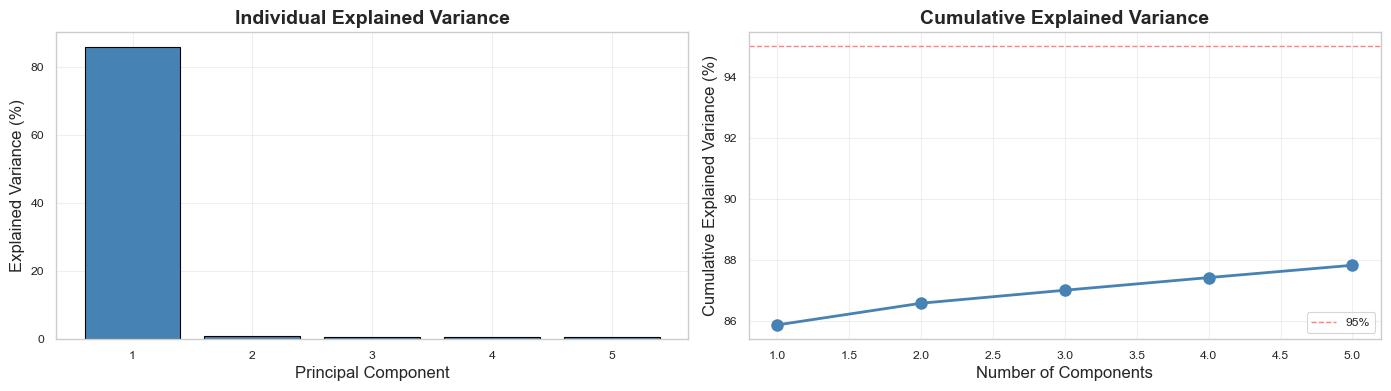


Visualizing PCA Reconstructions


In [4]:
# Create and train detector
detector = SADDetector(
    n_components=5,      # Number of principal components
    normalize=False,     # DON'T normalize - we want to preserve count rate info!
    aggregation_gap=2.0  # Merge alarms < 2 seconds apart
)

print("Training SAD detector...")
detector.fit(background_training)

# Check explained variance
var_ratios = detector.get_explained_variance_ratio()
cum_var = detector.get_cumulative_variance_explained()

print(f"\n✅ Training complete!")
print(f"\nExplained variance by component:")
for i, var in enumerate(var_ratios, 1):
    print(f"  PC{i}: {var*100:.2f}%")
print(f"\nCumulative variance explained: {cum_var*100:.2f}%")

# Visualize explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Individual variance
ax1.bar(range(1, len(var_ratios)+1), var_ratios*100, color='steelblue', edgecolor='black')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance (%)', fontsize=12)
ax1.set_title('Individual Explained Variance', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Cumulative variance
ax2.plot(range(1, len(var_ratios)+1), np.cumsum(var_ratios)*100, 'o-', 
         linewidth=2, markersize=8, color='steelblue')
ax2.axhline(95, color='red', linestyle='--', linewidth=1, alpha=0.5, label='95%')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance (%)', fontsize=12)
ax2.set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Visualizing PCA Reconstructions")
print("="*70)


## Visualize PCA Reconstructions

Let's see how well the PCA model reconstructs background spectra. Good reconstructions mean low SAD scores.


/Users/jghawaly/CODE/gammaflow/venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:197: RuntimeWarning: invalid value encountered in matmul
  return X @ self.components_ + self.mean_


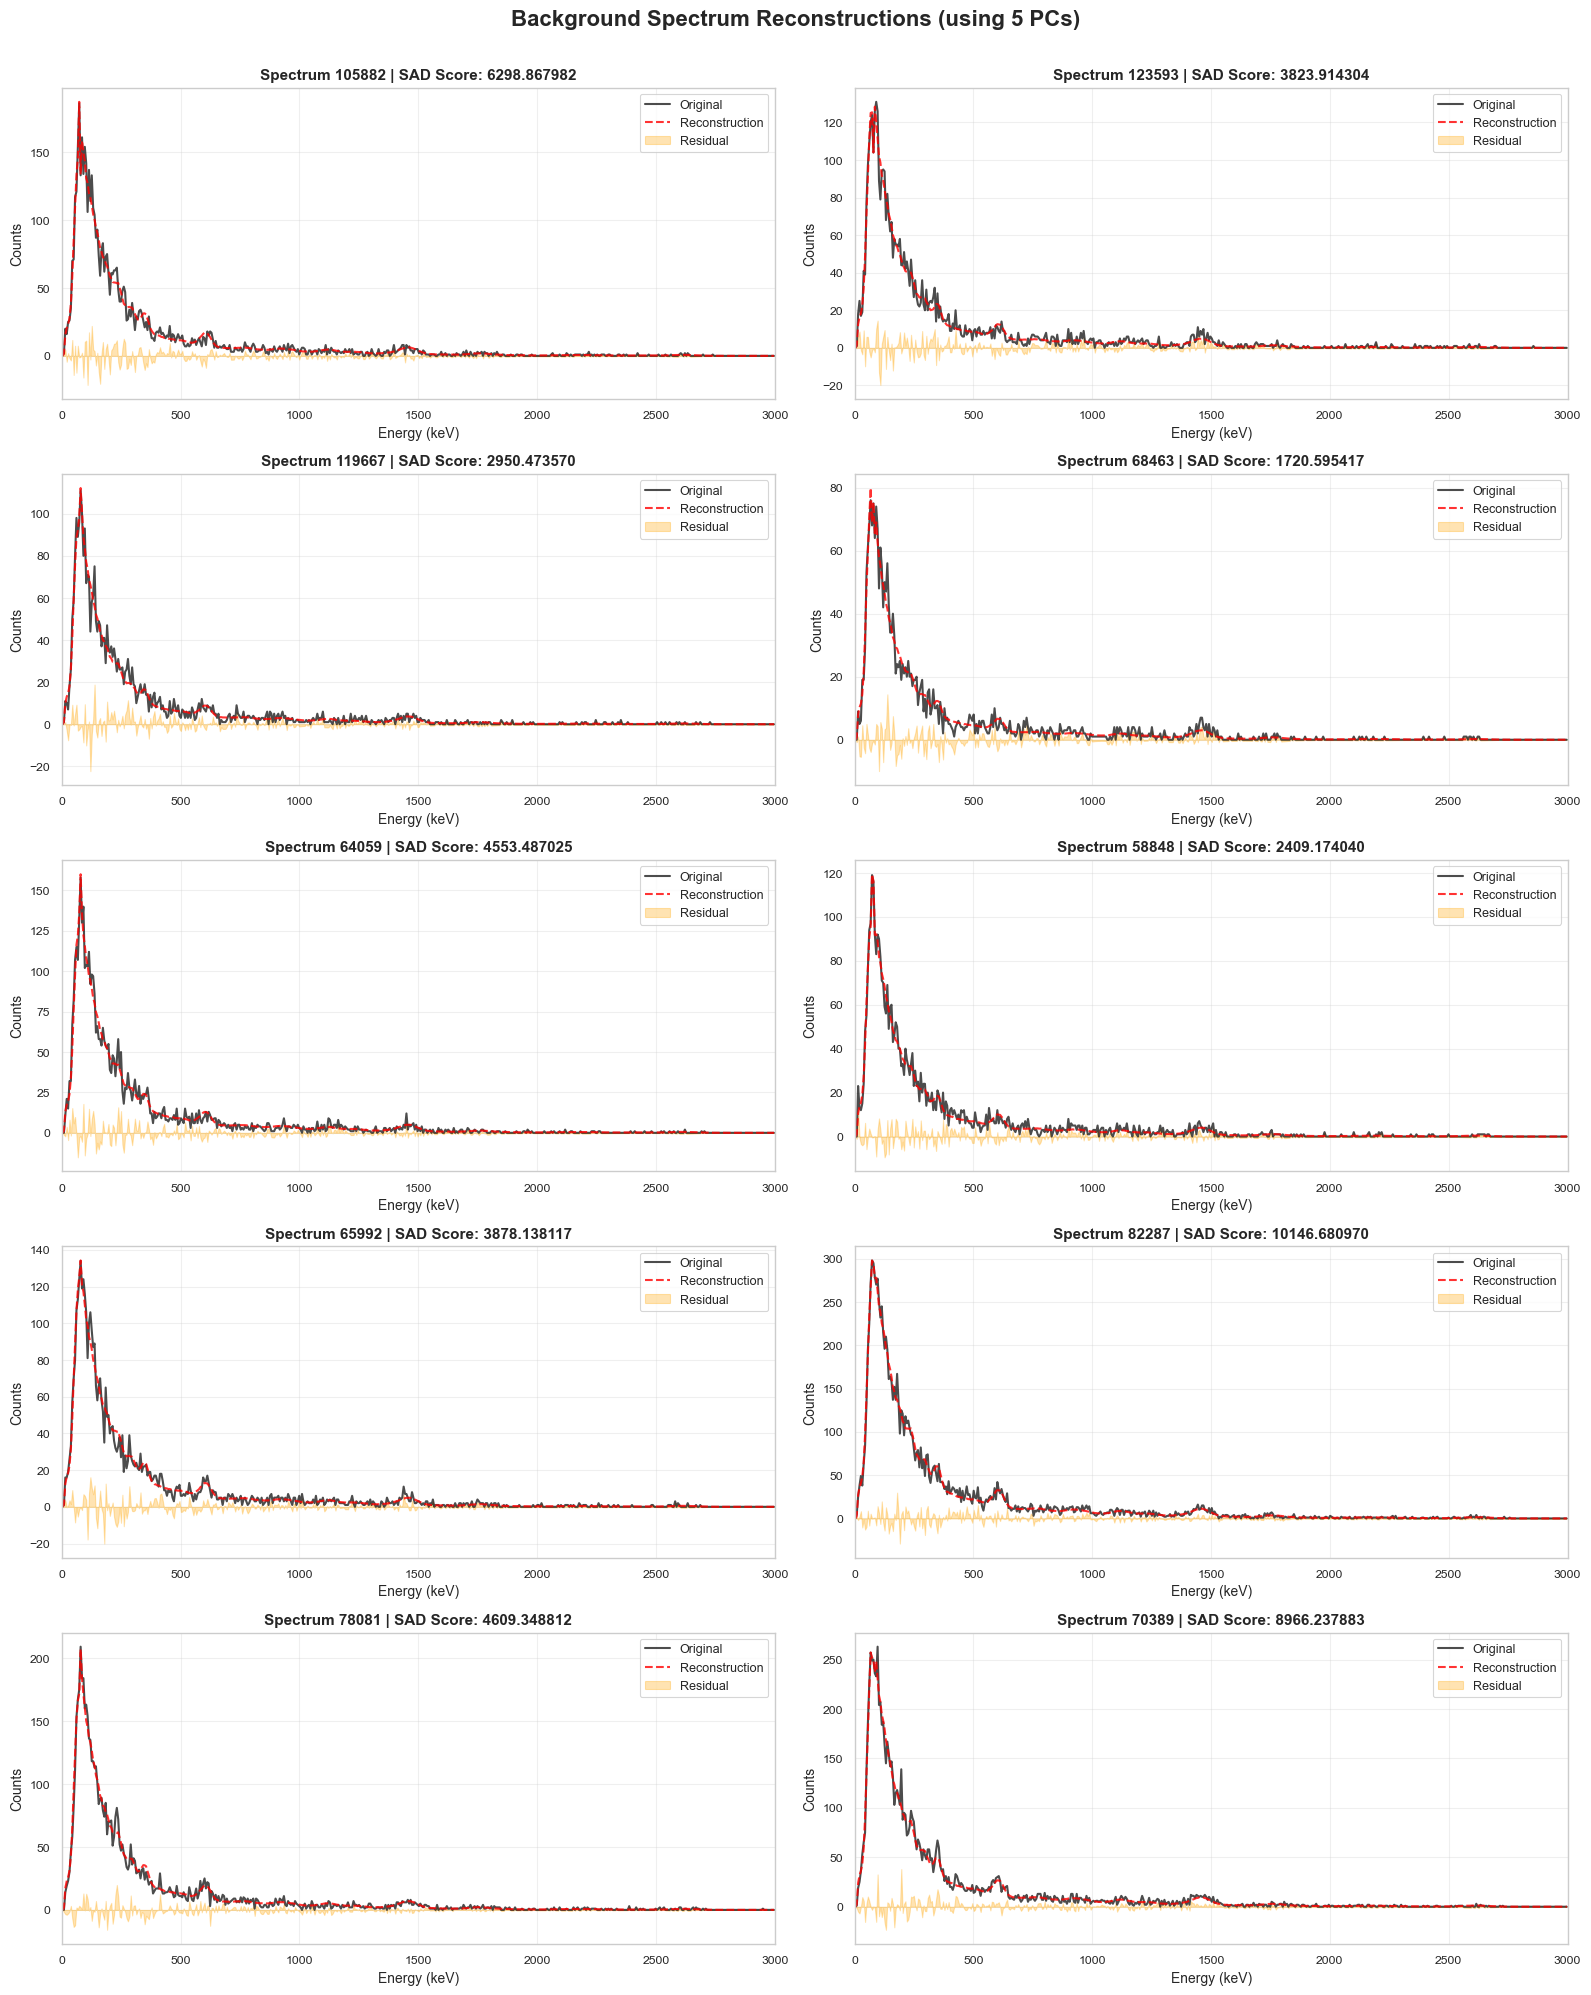


✅ PCA reconstruction quality visualization complete!


In [5]:
# Select 10 random background spectra to visualize
np.random.seed(42)
n_examples = 10
example_indices = np.random.choice(len(background_training.spectra), n_examples, replace=False)

# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for i, idx in enumerate(example_indices):
    spec = background_training.spectra[idx]
    
    # Prepare spectrum (same as detector does)
    if detector.normalize:
        counts = spec.counts / spec.counts.sum()
    else:
        counts = spec.counts
    
    # Get reconstruction from PCA
    X = counts.reshape(1, -1)
    X_reconstructed = detector.pca.inverse_transform(detector.pca.transform(X))
    
    # Calculate residual
    residual = X - X_reconstructed
    sad_score = np.sum(residual ** 2)
    
    # Get energy centers for plotting
    energy_centers = spec.energy_centers
    
    # Plot
    ax = axes[i]
    ax.plot(energy_centers, counts, 'k-', linewidth=1.5, alpha=0.7, label='Original')
    ax.plot(energy_centers, X_reconstructed[0], 'r--', linewidth=1.5, alpha=0.8, label='Reconstruction')
    ax.fill_between(energy_centers, 0, residual[0], alpha=0.3, color='orange', label='Residual')
    
    ax.set_xlabel('Energy (keV)', fontsize=10)
    ax.set_ylabel('Normalized Counts' if detector.normalize else 'Counts', fontsize=10)
    ax.set_title(f'Spectrum {idx} | SAD Score: {sad_score:.6f}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 3000)

plt.suptitle(f'Background Spectrum Reconstructions (using {detector.n_components} PCs)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

print(f"\n✅ PCA reconstruction quality visualization complete!")


## Set Threshold Based on False Alarm Rate

We'll calibrate the threshold using the **alarms per hour** metric, which is the standard for operational radiation detection systems. ANSI N42.48 typically requires **< 1 alarm/hour** for nuisance alarm rates.

This is different from simply thresholding a percentage of spectra, because:
- Alarm aggregation reduces the alarm count (consecutive high scores = 1 alarm)
- The metric is time-based, making it more operationally meaningful
- It accounts for temporal dynamics of the detector


Setting threshold for 0.5 alarms per hour (ANSI compliant)...
This uses iterative search to find the optimal threshold...

Reconstructing time series for FAR calculation...

✅ Threshold set: 8846.090136
   Converged to 0 alarms
   Achieved FAR: 0.00 alarms/hour

Calculating score distribution for visualization...


/Users/jghawaly/CODE/gammaflow/venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:197: RuntimeWarning: invalid value encountered in matmul
  return X @ self.components_ + self.mean_


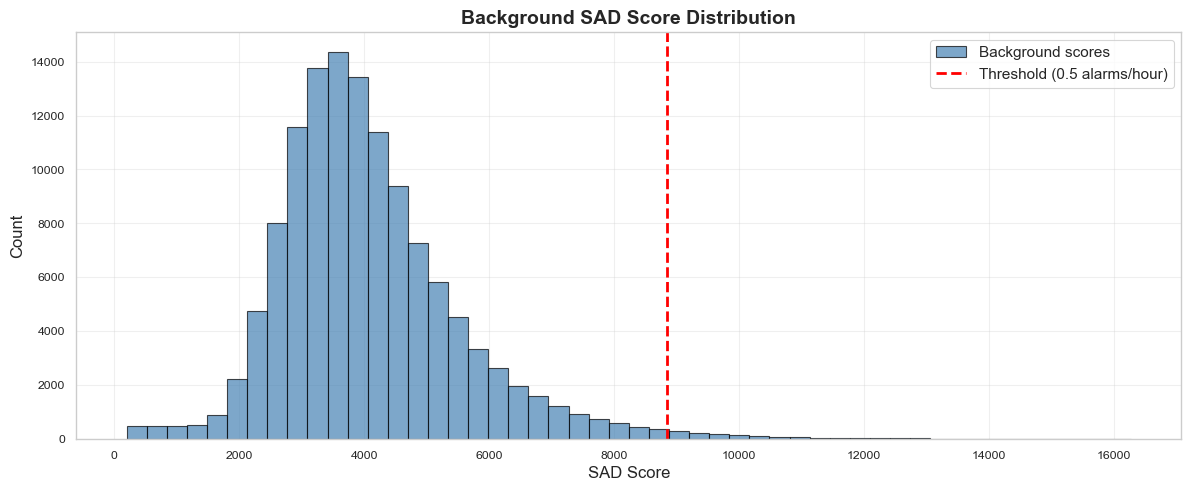


Score statistics:
  Spectra above threshold: 1409/124542 (1.13%)
  Note: Due to alarm aggregation, this doesn't directly map to alarm count


In [6]:
# Set threshold based on alarms per hour (ANSI standard metric)
# ANSI N42.48 typically requires < 1 alarm/hour
#
# NOTE: Using just the first background run for quick calibration and fair
# algorithm comparison.
#
# ⚠️  FOR REAL-WORLD/PRODUCTION USE: You should calibrate on MULTIPLE background
#     runs (e.g., 20+) to get robust statistics and account for environmental
#     variations, detector drift, and different background conditions. Using a
#     single run is acceptable for testing and algorithm comparison, but not
#     for operational deployment.
alarms_per_hour = 0.5  # Conservative target

print(f"Setting threshold for {alarms_per_hour} alarms per hour (ANSI compliant)...")
print("This uses iterative search to find the optimal threshold...")

# Need to convert Spectra to a time series for temporal FAR calculation
# Reconstruct time series from the individual runs
print("\nReconstructing time series for FAR calculation...")
detector.set_threshold_by_far(background_spectra_list[0], alarms_per_hour=alarms_per_hour)

print(f"\n✅ Threshold set: {detector.threshold:.6f}")
print(f"   Converged to {len(detector.alarms)} alarms")

# Calculate total observation time
total_time_hours = (background_spectra_list[0].timestamps[-1] - background_spectra_list[0].timestamps[0]) / 3600.0
actual_far = len(detector.alarms) / total_time_hours
print(f"   Achieved FAR: {actual_far:.2f} alarms/hour")

# Visualize score distribution and threshold
print("\nCalculating score distribution for visualization...")
all_scores = detector.score_time_series(background_spectra_list[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of scores
ax1 = axes[0]
ax1.hist(all_scores, bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(detector.threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Threshold = {detector.threshold:.6f}')
ax1.set_xlabel('SAD Score', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of SAD Scores on Background Data', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative distribution
ax2 = axes[1]
sorted_scores = np.sort(all_scores)
cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
ax2.plot(sorted_scores, cumulative, linewidth=2)
ax2.axvline(detector.threshold, color='red', linestyle='--', linewidth=2,
            label=f'Threshold = {detector.threshold:.6f}')
ax2.axhline(1 - (len(all_scores[all_scores > detector.threshold]) / len(all_scores)),
            color='green', linestyle=':', alpha=0.5,
            label=f'False positive rate')
ax2.set_xlabel('SAD Score', fontsize=12)
ax2.set_ylabel('Cumulative Probability', fontsize=12)
ax2.set_title('Cumulative Distribution Function', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nScore statistics:")
print(f"  Mean: {all_scores.mean():.6f}")
print(f"  Std: {all_scores.std():.6f}")
print(f"  Min: {all_scores.min():.6f}")
print(f"  Max: {all_scores.max():.6f}")
print(f"  Threshold percentile: {(all_scores < detector.threshold).sum() / len(all_scores) * 100:.2f}%")


## Test on Run with Source

Now let's test the detector on a run with a radioactive source.


In [12]:
# Load I-131 run with strongest source
# Find I-131 runs and sort by Speed/Offset (higher = stronger)
data_path = Path('../topcoder')
answer_key = pd.read_csv(data_path / 'scorer' / 'answerKey_training.csv')
i131_runs = answer_key[answer_key['SourceID'] == 3].copy()
i131_runs = i131_runs.sort_values('Speed/Offset', ascending=False)

# Pick the strongest run
test_run_id = i131_runs.iloc[0]['RunID']
speed_offset = i131_runs.iloc[0]['Speed/Offset']

print(f"Loading I-131 test run {test_run_id}...")
print(f"  Speed/Offset: {speed_offset:.2f} (stronger is better)")
listmode, metadata = load_listmode_run(int(test_run_id))

print(f"\nRun Metadata:")
print(f"  Source: {metadata['SourceName']}")
print(f"  Source Time: {metadata['SourceTime']:.1f} seconds")
print(f"  Speed/Offset: {metadata['Speed/Offset']:.2f}")
print(f"\n{listmode}")

# Convert to time series with 1-second integration
print("\nConverting to SpectralTimeSeries...")
test_time_series = SpectralTimeSeries.from_list_mode(
    listmode,
    integration_time=1.0,
    stride_time=1.0,
    energy_bins=512,
    energy_range=(0, 3000)
)

print(f"\nCreated: {test_time_series}")
print(f"  Number of spectra: {test_time_series.n_spectra}")
print(f"  Time coverage: {test_time_series.timestamps[0]:.1f} to {test_time_series.timestamps[-1]:.1f} s")


Loading I-131 test run 107172.0...
  Speed/Offset: 2.17 (stronger is better)

Run Metadata:
  Source: I-131
  Source Time: 34.2 seconds
  Speed/Offset: 2.17

ListMode(n_events=51353, duration=51.83s, rate=990.8Hz)

Converting to SpectralTimeSeries...

Created: SpectralTimeSeries(n_spectra=52, n_bins=512, calibrated, calibration_mode=shared)
  Number of spectra: 52
  Time coverage: 0.5 to 51.5 s


## Run SAD Detection


In [13]:
print(f"Running SAD Detection")
print(f"{'='*70}")
print(f"  n_components: {detector.n_components}")
print(f"  Threshold: {detector.threshold:.6f}")
print(f"  Normalize: {detector.normalize}")
print()

# Process time series
sad_scores = detector.process_time_series(test_time_series)

# Get summary
summary = detector.get_alarm_summary()

print(f"\n{'='*70}")
print(f"Detection Results")
print(f"{'='*70}")
print(f"Number of alarms: {summary['n_alarms']}")
print(f"Total alarm time: {summary['total_alarm_time']:.2f} seconds")
if summary['n_alarms'] > 0:
    print(f"Mean alarm duration: {summary['mean_duration']:.2f} seconds")
    print(f"Peak SAD score: {summary['max_peak_metric']:.6f}")

if detector.alarms:
    print(f"\nAlarm Events:")
    true_source_time = metadata['SourceTime']
    for i, alarm in enumerate(detector.alarms, 1):
        print(f"  {i}. {alarm}")
        # Compare to ground truth
        if alarm.start_time <= true_source_time <= alarm.end_time:
            print(f"      ✅ Captured true source (t={true_source_time:.1f}s)")
        else:
            time_diff = min(abs(alarm.start_time - true_source_time),
                          abs(alarm.end_time - true_source_time))
            print(f"      ⚠️  Offset from true source: {time_diff:.1f}s")


Running SAD Detection
  n_components: 5
  Threshold: 8846.090136
  Normalize: False


Detection Results
Number of alarms: 1
Total alarm time: 1.00 seconds
Mean alarm duration: 1.00 seconds
Peak SAD score: 29493.256086

Alarm Events:
  1. AlarmEvent(start=34.50s, end=35.50s, peak=29493.26 at 34.50s, duration=1.00s)
      ⚠️  Offset from true source: 0.3s


/Users/jghawaly/CODE/gammaflow/venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:197: RuntimeWarning: invalid value encountered in matmul
  return X @ self.components_ + self.mean_


## Visualize Results


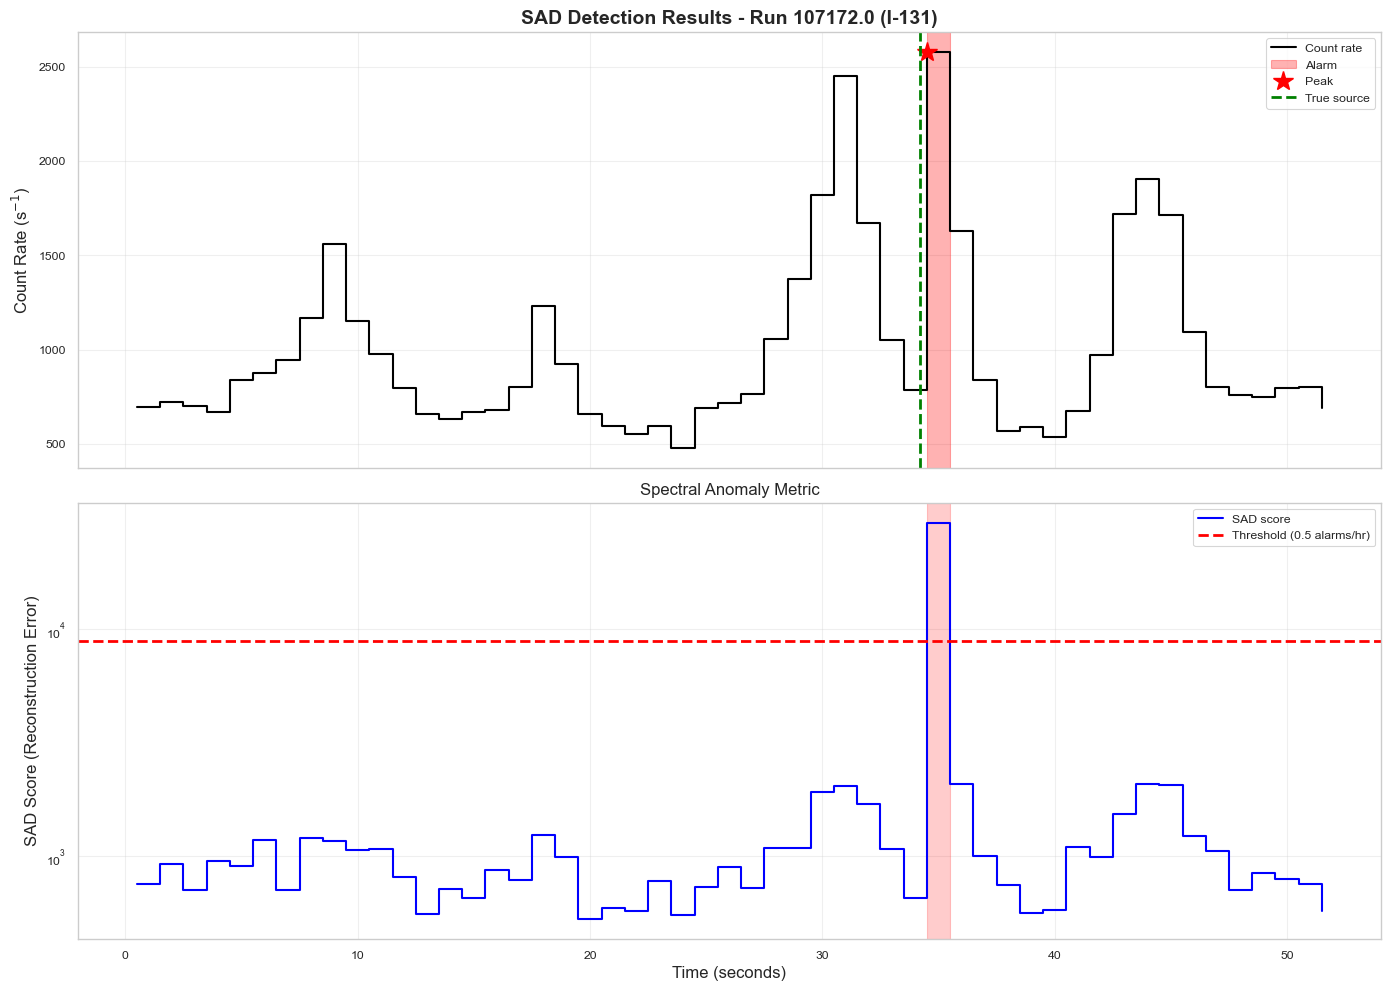


✅ Visualization complete!


In [14]:
# Plot SAD scores with alarm overlay
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Get times and count rates
times = test_time_series.timestamps
count_rates = np.array([
    float(s.counts.sum()) / float(s.live_time if s.live_time is not None else s.real_time)
    for s in test_time_series.spectra
])

# Plot 1: Count rate
ax1.step(times, count_rates, where='post', color='black', linewidth=1.5, label='Count rate')
ax1.set_ylabel(r'Count Rate (s$^{-1}$)', fontsize=12)
ax1.set_title(f'SAD Detection Results - Run {test_run_id} ({metadata["SourceName"]})', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Overlay alarm regions
for i, alarm in enumerate(detector.alarms):
    ax1.axvspan(alarm.start_time, alarm.end_time, alpha=0.3, color='red', 
                label='Alarm' if i == 0 else '')
    # Mark peak
    peak_idx = np.argmin(np.abs(times - alarm.peak_time))
    ax1.plot(alarm.peak_time, count_rates[peak_idx],
            'r*', markersize=15, label='Peak' if i == 0 else '')

# Mark true source time
if metadata['SourceID'] != 0:
    ax1.axvline(metadata['SourceTime'], color='green', linestyle='--', 
                linewidth=2, label='True source')

ax1.legend(loc='best')

# Plot 2: SAD scores
ax2.step(times, sad_scores, where='post', color='blue', linewidth=1.5, label='SAD score')
ax2.axhline(detector.threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Threshold ({alarms_per_hour} alarms/hr)')
ax2.set_xlabel('Time (seconds)', fontsize=12)
ax2.set_ylabel('SAD Score (Reconstruction Error)', fontsize=12)
ax2.set_title('Spectral Anomaly Metric', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

# Use log scale for better visibility
ax2.set_yscale('log')

# Overlay alarm regions on metric plot too
for alarm in detector.alarms:
    ax2.axvspan(alarm.start_time, alarm.end_time, alpha=0.2, color='red')

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")
